In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import os
import ast
import seaborn as sns

sns.set()

%matplotlib inline

import qctoolkit as qtk # https://github.com/SamKChang/qctoolkit
qtk.setting.quiet = True

In [150]:
# ccs instance that defines the compound space
mol_base = qtk.Molecule('xyz/gaas_2.xyz')
mol_base.extend([3,3,3], normalize=True)
ccs = qtk.CCS(mol_base, 'ccs.yml')
# optimization log
log01 = qtk.Logger('optimization/algaas_333_01.db')
log02 = qtk.Logger('optimization/algaas_333_02.db')
log03 = qtk.Logger('optimization/algaas_333_03.db')
log04 = qtk.Logger('optimization/algaas_333_04.db')
log05 = qtk.Logger('optimization/algaas_333_05.db')
log06 = qtk.Logger('optimization/algaas_333_06.db')

# Sanity checks on radial distribution function

To make sure radial distribution function is bug free, detail checks is done on small systems where the actual atom pair distance can be counted by hand. All checks below give correct results and therefore there is no clue for bugs in $g(r)$ calculations.

## 211 fcc supercell 
**2 Ga and 2 As**

Conventionally, $g_{\rm GaAs}(r)$ is radially normalized, meaning 
$$
g_{\rm GaAs}(r) = \frac{N_{\rm GaAs}(r)}{4\pi r^2},
$$
where $N_{\rm GaAs}(r)$ is the number of Ga-As pair as distance $r$. 
The method **gr** takes a flag **radial_normalization** to return either $g(r)$ or $N(r)$ depending on selected atom types.

N(r): [ 3.  1.] , r: [ 2.4475  6.1625]


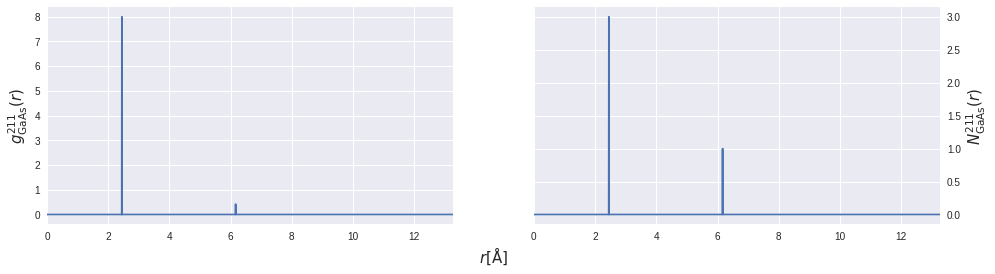

In [3]:
def basic_check():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_211 = mol_base.copy()
    mol_211.extend([2,1,1], normalize=True)
    
    r, g = mol_211.gr('Ga', 'As', radial_normalization=True)
    r, N = mol_211.gr('Ga', 'As', radial_normalization=False)
    
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(16,4))
    ax1.plot(r, g)
    ax1.set_xlim(r.min(), r.max())
    ax1.set_xlabel(r'$r [{\rm \AA}]$',x=1.1, fontsize=15)
    ax1.set_ylabel(r'$g_{\rm GaAs}^{211}(r)$', fontsize=15)
    ax2.plot(r, N)
    print "N(r):", N[N>0], ", r:", r[N>0]
    ax2.set_xlim(r.min(),r.max())
    ax2.set_ylabel(r'$N_{\rm GaAs}^{211}(r)$', fontsize=15)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    pass

basic_check()

$N_{\rm GaAs}^{211}(r)$ correctly gives 3 Ga-As pair at 2.4 angstrom and 1 Ga-As pair at 6.1 angstrom.

## 311, 221, 222 fcc supercells

311
N(r): [ 5.  3.  1.]
r: [  2.4475   6.1625  10.0925]

221
N(r): [ 8.  3.  4.  1.]
r: [ 2.4475  4.6875  6.1625  9.2675]

222
N(r): [ 20.  21.  12.   4.   6.   1.]
r: [  2.4475   4.6875   6.1625   7.3425   9.2675  12.2425]



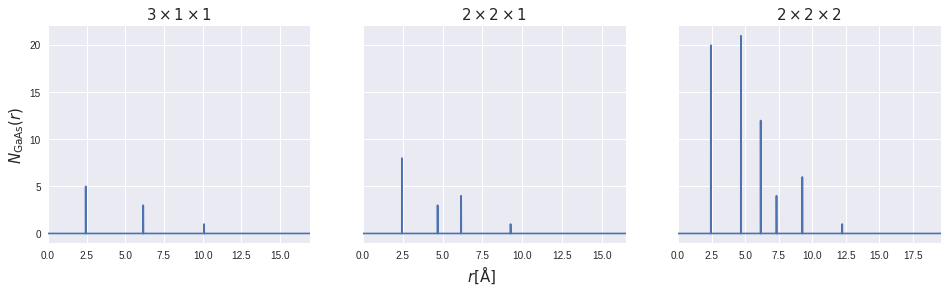

In [4]:
def cell_check():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_311 = mol_base.copy()
    mol_311.extend([3,1,1], normalize=True)
    mol_311.symmetry=False
    mol_311.write('test_311.xyz')

    mol_221 = mol_base.copy()
    mol_221.extend([2,2,1], normalize=True)
    mol_221.symmetry=False
    mol_221.write('test_221.xyz')

    mol_222 = mol_base.copy()
    mol_222.extend([2,2,2], normalize=True)
    mol_222.symmetry=False
    mol_222.write('test_222.xyz')

    mols = [mol_311, mol_221, mol_222]
    names = [r'$3\times 1\times1$', r'$2\times 2\times 1$', r'$2\times 2\times 2$']
    systems = ['311', '221', '222']

    fig, axs = plt.subplots(1, 3, figsize=(16,4), sharey=True)

    for i in range(3):
        mol = mols[i]
        ax = axs[i]
        r, N = mol.gr('Ga', 'As', radial_normalization=False)
        print systems[i]
        print "N(r):", N[N>0]
        print "r:", r[N>0]
        print 
        ax.plot(r, N)
        ax.set_xlim(r.min(),r.max())
        ax.set_title(names[i], fontsize=15)
    axs[0].set_xlabel(r'$r [{\rm \AA}]$',x=1.65, fontsize=15)
    axs[0].set_ylabel(r'$N_{\rm GaAs}(r)$', fontsize=15)

cell_check()

Number of Ga-As pair counts at each distance are correct, note that the fcc primitive cell is not orthorhombic.

## 311 AlGaAs supercell
**4 fcc primitive cells with 1 Ga mutates to Al**

Ga-As
N(r): [ 4.  2.]
r: [ 2.4475  6.1625]

Al-As
N(r): [ 1.  1.  1.]
r: [  2.4475   6.1625  10.0925]

Al-Ga
N(r): [ 1.  1.]
r: [ 3.9975  7.9975]



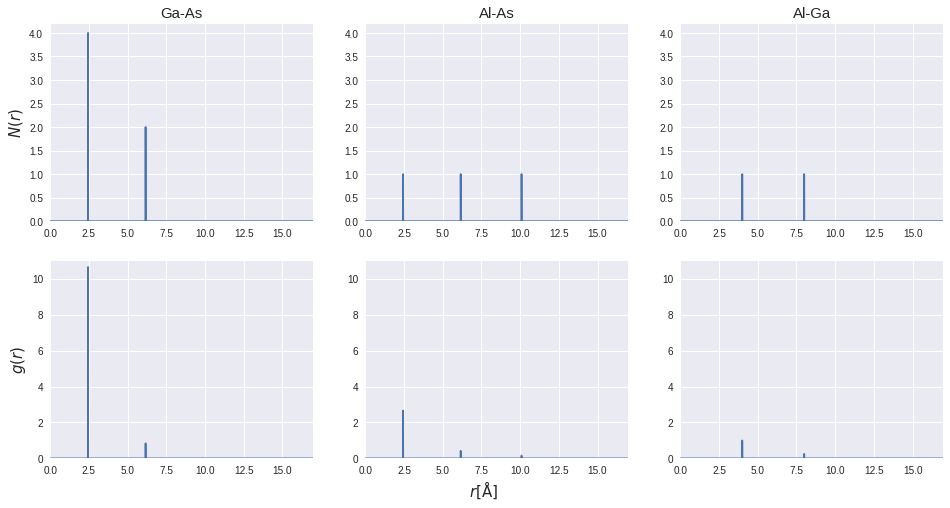

In [5]:
def plot_311_mixed():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    algaas = mol_base.copy()
    algaas.extend([3,1,1], normalize=True)
    algaas.symmetry=False
    algaas.setAtoms(0, Z=13)
    algaas.write('test_algaas.xyz')

    r, N_gaas = algaas.gr('Ga', 'As', radial_normalization=False)
    r, N_alas = algaas.gr('Al', 'As', radial_normalization=False)
    r, N_alga = algaas.gr('Al', 'Ga', radial_normalization=False)
    r, g_gaas = algaas.gr('Ga', 'As', radial_normalization=True)
    r, g_alas = algaas.gr('Al', 'As', radial_normalization=True)
    r, g_alga = algaas.gr('Al', 'Ga', radial_normalization=True)
    N_all = [N_gaas, N_alas, N_alga]
    g_all = [g_gaas, g_alas, g_alga]
    titles = ['Ga-As', 'Al-As', 'Al-Ga']

    fig, [axs, axs_2] = plt.subplots(2, 3, figsize=(16,8))

    for i in range(3):
        ax = axs[i]
        ax2 = axs_2[i]
        N = N_all[i]
        g = g_all[i]
        print titles[i]
        print "N(r):", N[N>0]
        print "r:", r[N>0]
        print 
        ax.plot(r, N)
        ax.set_xlim(r.min(),r.max())
        ax.set_title(titles[i], fontsize=15)
        ax.set_ylim(0,4.2)
        ax2.set_ylim(0,11)
        ax2.plot(r, g)
        ax2.set_xlim(r.min(),r.max())
    axs[0].set_ylabel(r'$N(r)$', fontsize=15)
    axs_2[0].set_xlabel(r'$r [{\rm \AA}]$',x=1.65, fontsize=15)
    axs_2[0].set_ylabel(r'$g(r)$', fontsize=15)

plot_311_mixed()

It can be easily verified that $N_{\rm GaAs}^{\rm AlGaAs}(r) + N_{\rm AlAs}^{\rm AlGaAs}(r) = N_{\rm GaAs}^{\rm GaAs}(r)$, where the nearest, second nearset, and the third nearest distance counts are

$$
\begin{array}{lcl}
N_{\rm GaAs}^{\rm AlGaAs}(r) &=& (4, 2, 0)\\
N_{\rm AlAs}^{\rm AlGaAs}(r) &=& (1, 1, 1)\\
N_{\rm GaAs}^{\rm GaAs}(r) &=& (5, 3, 1)
\end{array}
$$

## Analysis on optimized a crystal 
**$3\times 3\times 3$ supercell with 27 III-sites (Ga or Al) and 27 As**

In [6]:
def opt_rdf_test(radial_normalization=False):

    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)

    # extract best molecules from optimization
    mols = []

    N_mol = 3

    for entry in log01.list(order='descent')[:N_mol]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))


    mol_name = ['Best crystal', 'Second best crystal', 'Third best crystal']
    
    fig, axarr = plt.subplots(N_mol, 4, figsize=(16, 4*N_mol), sharex=True, sharey=True)
    r, y_base = mol_base.gr('Ga', 'As', radial_normalization=radial_normalization)
    if radial_normalization:
        y_name = 'g'
    else:
        y_name = 'N'
    
    for i in range(N_mol):

        mol = mols[i]

        r, y_GaAs = mol.gr('Ga', 'As', radial_normalization=radial_normalization)
        r, y_AlAs = mol.gr('Al', 'As', radial_normalization=radial_normalization)
        y_diff = y_GaAs + y_AlAs - y_base
        y_diff[np.abs(y_diff) < 1E-5] = 0
        y_all = [y_GaAs + y_AlAs, y_GaAs, y_AlAs, y_diff]

        for j in range(4):
            ax = axarr[i, j]
            y = y_all[j]
            ax.plot(r, y)
            ax.set_xlim(2, 20)
            
            if j == 0:
                y_min, y_max = ax.get_ylim()
            else:
                ax.set_ylim(y_min, y_max)
            
            if j == 3:
                try:
                    ax.set_ylabel(mol_name[i], fontsize=15)
                    ax.yaxis.set_label_position('right')
                except:
                    pass

    axarr[N_mol-1,0].set_xlabel(r'$r [\rm \AA]$', x=2.3, fontsize=15)
    axarr[N_mol-1,0].set_ylabel(r'$%s(r)$' % y_name, y=1.65, fontsize=15)
    axarr[0, 0].set_title(r'${}_{{\rm GaAs}}(r)+{}_{{\rm AlAs}}(r)$'.format(y_name, y_name), fontsize=15)
    axarr[0, 1].set_title(r'${}_{{\rm GaAs}}(r)$'.format(y_name), fontsize=15)
    axarr[0, 2].set_title(r'${}_{{\rm AlAs}}(r)$'.format(y_name), fontsize=15)
    axarr[0, 3].set_title(
        r'${}_{{\rm GaAs}}(r)+{}_{{\rm AlAs}}(r)-{}_{{\rm GaAs}}^{{\rm ref}}(r)$'.format(
            y_name, y_name, y_name
        ), 
        fontsize=15
    )
    return fig

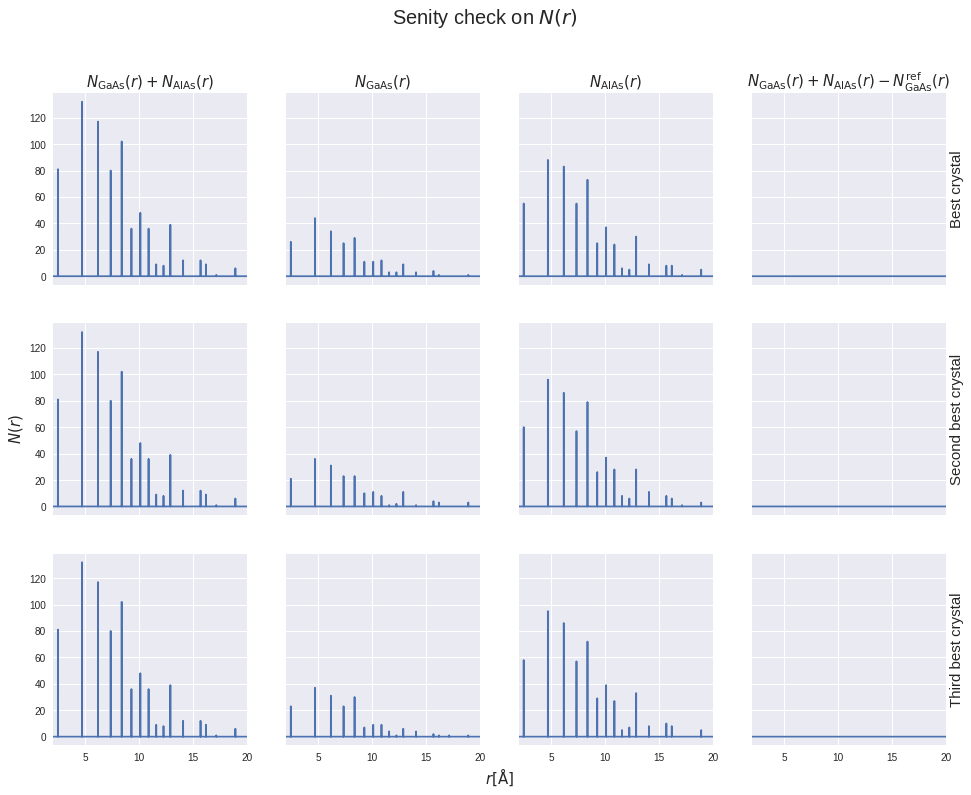

In [7]:
opt_rdf_test()
plt.suptitle(r'Senity check on $N(r)$', fontsize=20)
pass

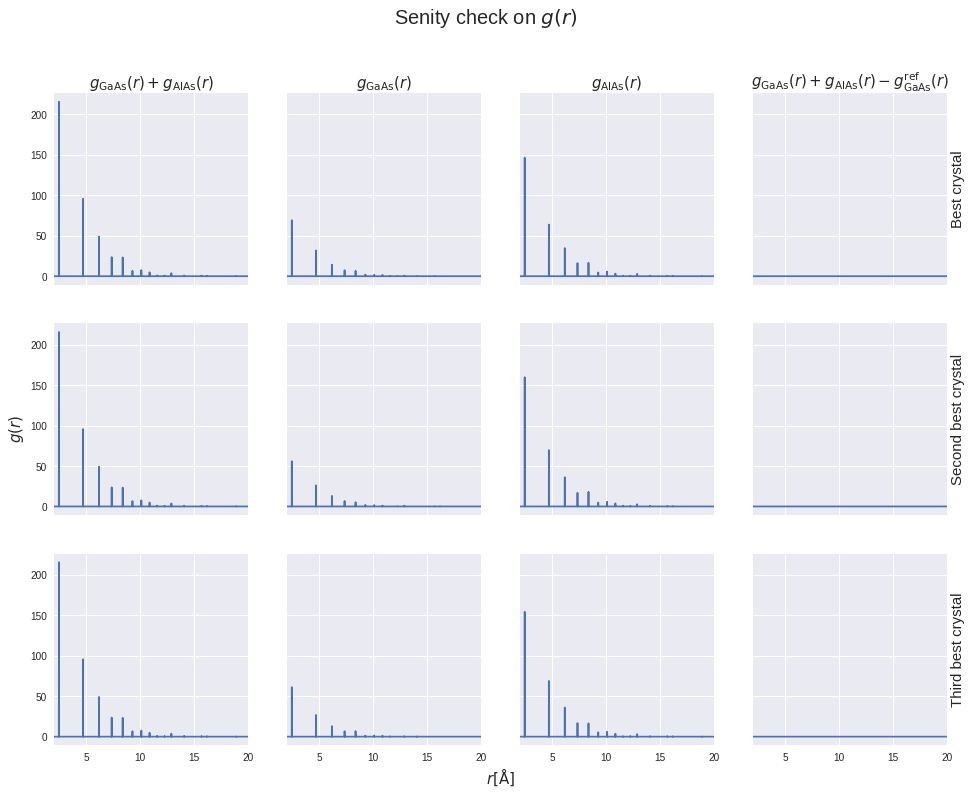

In [8]:
opt_rdf_test(True)
plt.suptitle(r'Senity check on $g(r)$', fontsize=20)
pass

# Structual analysis on optimized crystals

Having thoroughly tested the code for **g(r)** calculation, I am confident the results is bug free. Since it is easier to understand $N(r)$ than $g(r)$, the analysis below will focus only on $N(r)$ for various cases. The goal is to extract some features in $N(r)$ of the best crystals, which could be used as an indicator of the band gap.

## $N_{\rm AlAs}(r)$ for the best crystals

As shown above, $N_{\rm AlAs}(r) + N_{\rm GaAs}(r) = N_{\rm GaAs}^{\rm ref}(r)$, I only need to focus on $N_{\rm AlAs}(r)$. In order to show the structrual variations, it is compared with scaled $N_{\rm GaAs}^{\rm ref}(r)$. That is I am looking at the quantity

$$
\Delta N_{\rm AlAs}(r) = N_{\rm AlAs}(r) - x N_{\rm GaAs}^{\rm ref}(r),
$$

or

$$
\Delta N_{\rm GaAs}(r) = N_{\rm GaAs}(r) - (1-x) N_{\rm GaAs}^{\rm ref}(r),
$$

where $x$ is the mole fraction of Al in the optimized Al$_x$Ga$_{1-x}$As crystals. Note that 

$$
\Delta N_{\rm AlAs}(r) + \Delta N_{\rm GaAs}(r) = N_{\rm AlAs}(r) + N_{\rm GaAs}(r) - N_{\rm GaAs}^{\rm ref}(r) = 0
$$

In [9]:
def dN_AlAs_test(N_mol, log, title_str=''):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)

    mols = []
    for entry in log.list(order='descent')[:N_mol**2]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))

    dN_tops = []
    x_list = []
    for mol in mols:
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        dN_tops.append(N - x*N_ref)
        x_list.append(x)

    dN_tops = np.vstack(dN_tops)

    fig, axarr = plt.subplots(N_mol, N_mol, figsize=(16, 12), sharex=True, sharey=True)

    for i in range(N_mol):
        for j in range(N_mol):
            k = j + i*N_mol
            ax = axarr[i, j]
            ax.plot(r, dN_tops[k])
            ax.set_title("rank: %d, x=%4.2f" % ((k+1), x_list[k]))
    axarr[0, 0].set_xlim(2, 20)
    axarr[N_mol-1, 0].set_xlabel(r'$r$ [${\rm \AA}$]', fontsize=15, x = float(N_mol)/2 + 0.35)
    axarr[N_mol-1, 0].set_ylabel(r'$\Delta N_{\rm AlAs}(r)$', fontsize=15, y = float(N_mol)/2 + 0.45)
    plt.suptitle(r'$\Delta N_{{\rm AlAs}}(r)$ of top {} cystals '.format(N_mol**2) + title_str, fontsize=20)
    pass

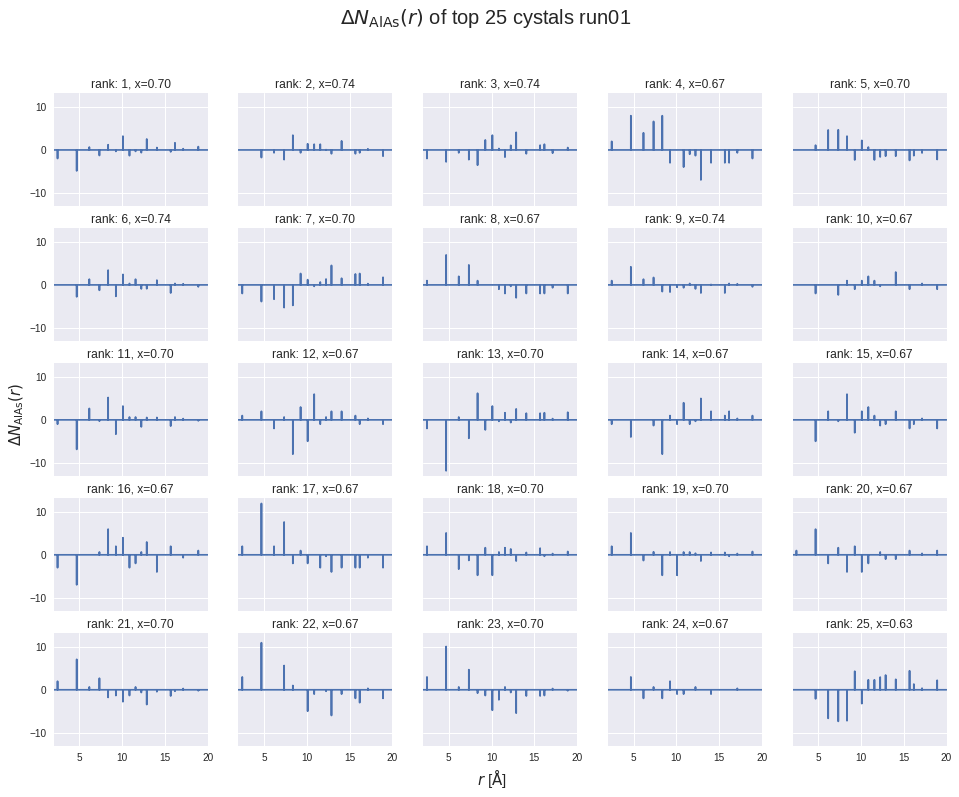

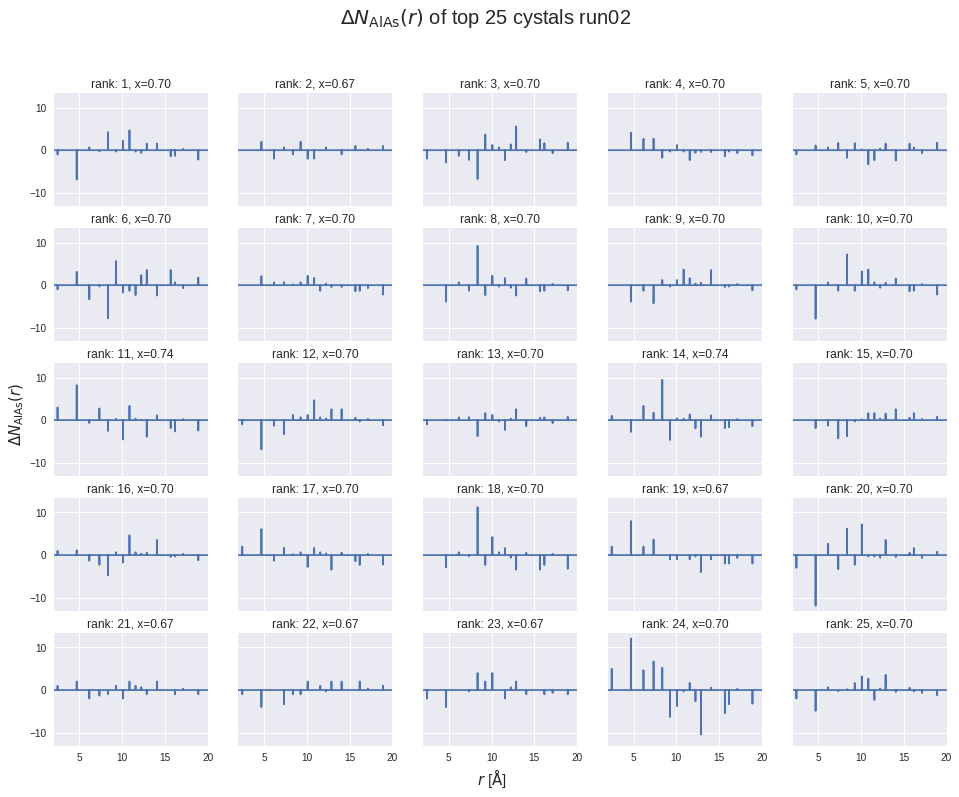

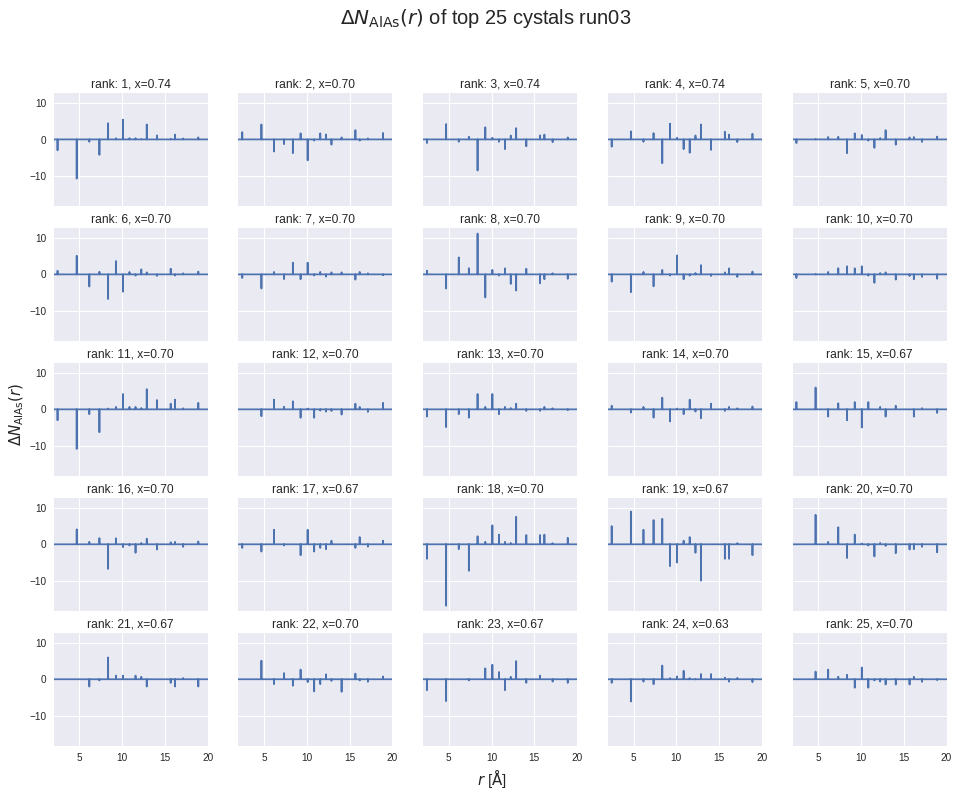

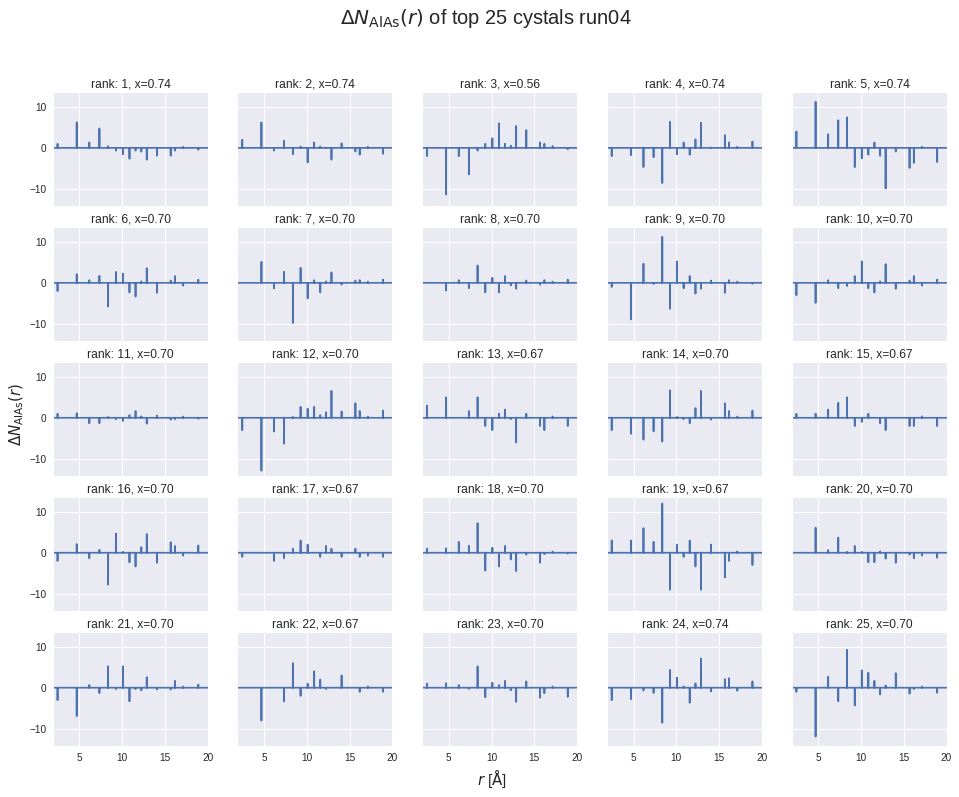

In [10]:
dN_AlAs_test(5, log01, 'run01')
dN_AlAs_test(5, log02, 'run02')
dN_AlAs_test(5, log03, 'run03')
dN_AlAs_test(5, log04, 'run04')

In [11]:
def dN_AlAs_average(N_mol, log):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    mols = []
    for entry in log.list(order='descent')[:N_mol**2]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))
    
    dN_tops = []
    x_list = []
    for mol in mols:
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        dN_tops.append(N - x*N_ref)
    dN_tops = np.vstack(dN_tops)

    dN_mean = dN_tops.mean(0)
    dN_err = dN_tops.std(0)

    ax.plot(r, N_ref, label=r'$N_{\rm GaAs}^{\rm ref}(r)$', zorder=10)

    (_, caps, _) = ax.errorbar(
        r[N_ref>0], dN_mean[N_ref>0],
        yerr=[dN_err[N_ref > 0], dN_err[N_ref > 0]],
        ls='',
        capsize=7,
        fmt='o',
        color='orange',
        label=r'$\overline{\Delta N}_{\rm AlAs}(r)$',
        zorder=11
    )
    for cap in caps:
        cap.set_markeredgewidth(1)
    ax.plot(r[N_ref > 0], dN_tops[0][N_ref > 0], 
        ls='', marker='s', color='forestgreen',zorder=12, label=r'$\Delta N_{\rm AlAs}^{\rm best}(r)$'
    )
    ax.set_title(r"Averaged $\Delta N_{{\rm AlAs}}(r)$ over top {} crystals".format(N_mol), fontsize=20)
    ax.set_ylabel(r'$\overline{\Delta N}_{\rm AlAs}(r)$', fontsize=15)
    ax.set_xlabel(r'$r$ [${\rm \AA}$]', fontsize=15)
    ax.set_xlim(2, 20)

    ax.legend(fontsize=15)
    pass

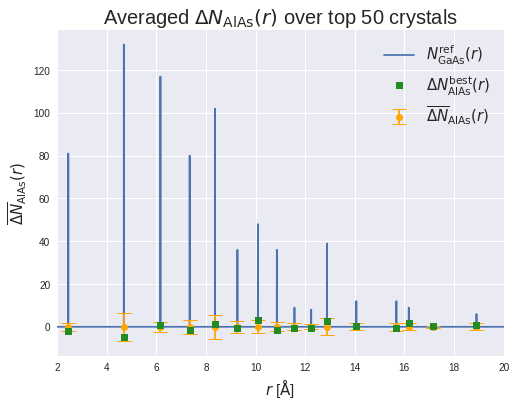

In [12]:
dN_AlAs_average(50, log01)

It turned out that there is no obvious general feature of $\Delta N_{\rm AlAs}(r)$ among the best crystals. The next attempt is to find the clusters of $N_{\rm AlAs}(r)$ among the best crystals.

## $N_{\rm AlAs}(r)$ clusters
** The analysis is done by SVD and transformed to PCA **

**Note on SVD**
Let the $m\times n$ data matrix $\mathbf{D}$, which consists of $m$ radial count function $N_1(r), N_2(r), \cdots,N_m(r)$ evaluated on $n$ distances $r_1, r_2, \cdots, r_n$, be the form
$$
\mathbf{D} = \left(\begin{array}{c}
N_1(r)\\
N_2(r)\\
\vdots\\
N_m(r)\\
\end{array}\right)
=
\left(
\begin{array}{cccc}
N_1(r_1) & N_1(r_2) & \cdots & N_1(r_n) \\
N_2(r_1) & N_1(r_2) & \cdots & N_2(r_n) \\
\vdots & \vdots & \ddots & \vdots \\
N_m(r_1) & N_m(r_2) & \cdots & N_m(r_n) \\
\end{array}
\right).
$$

Singular value decomposition of $\mathbf{D}$ is
$$
\mathbf{D} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\rm T},
$$
where 
* $\mathbf{U}$: $m\times m$ unitary matrix
* $\mathbf{\Sigma}$: $m\times n$ diagonal matrix
* $\mathbf{V}$: $n\times n$ unitary matrix

Each of the radial count function ($m$-dimensional vector in this case) is decomposed by
$$
\big(N_i(r_1), N_i(r_2), \cdots, N_i(r_n)\big) = \sum_{j=1}^m a_{ij}V_{ji},
$$
wehre $a_{ij} = [\mathbf{U}\mathbf{\Sigma}]_{ij}$. In other words, the column vectors of $\mathbf{V}$ form a orthogonal basis to expand the data matrix $\mathbf{D}$. Or in other words, $a_{ij} = \mathbf{N}_i \cdot \mathbf{V}_j$, where $\mathbf{N}_i$ is the descritized $N_i(r)$ and $\mathbf{V}_j$ is the $j^{th}$ column vector of $\mathbf{V}$

The following section perfrom SVD and reconstruct data matrix by $\mathbf{U}$, $\mathbf{\Sigma}$, and $\mathbf{V}$

In [13]:
# compare with standard pca library results
from sklearn.decomposition import PCA

In [14]:
def get_dN(N_mol, log, N_start=0):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)
    
    N_list = []
    for entry in log.list(order='descent')[N_start:N_mol]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mol = ccs.generate(**ccs_coord)
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        N_list.append(N - x*N_ref)
    return np.vstack(N_list)

# data matrix: 20 samples
# D = np.random.random([10, 20])
D = get_dN(20, log01)
D_test = get_dN(20, log02)
D_test2 = get_dN(1100, log02, 1080)

U, s, Vt = np.linalg.svd(D)
V = Vt.T
S = np.diag(s)

print "U:", U.shape
print "S:", S.shape, "(numpy output only diagonal values of Sigma)"
print "V:", V.shape

A = U.dot(S)

U: (20, 20)
S: (20, 20) (numpy output only diagonal values of Sigma)
V: (5876, 5876)


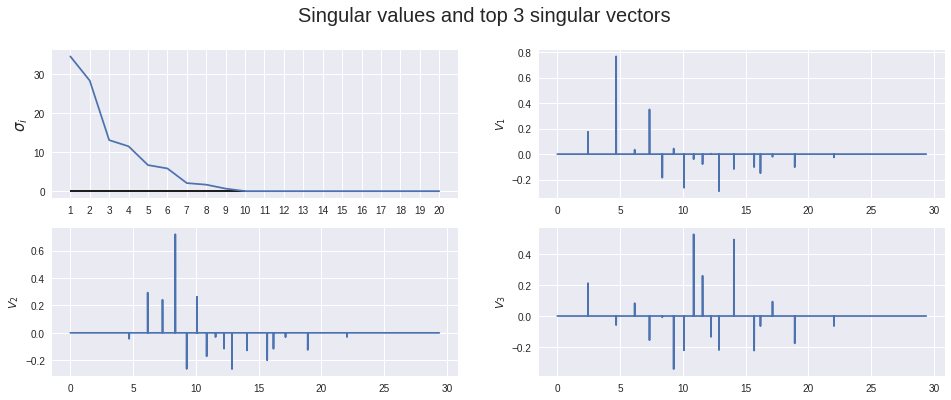

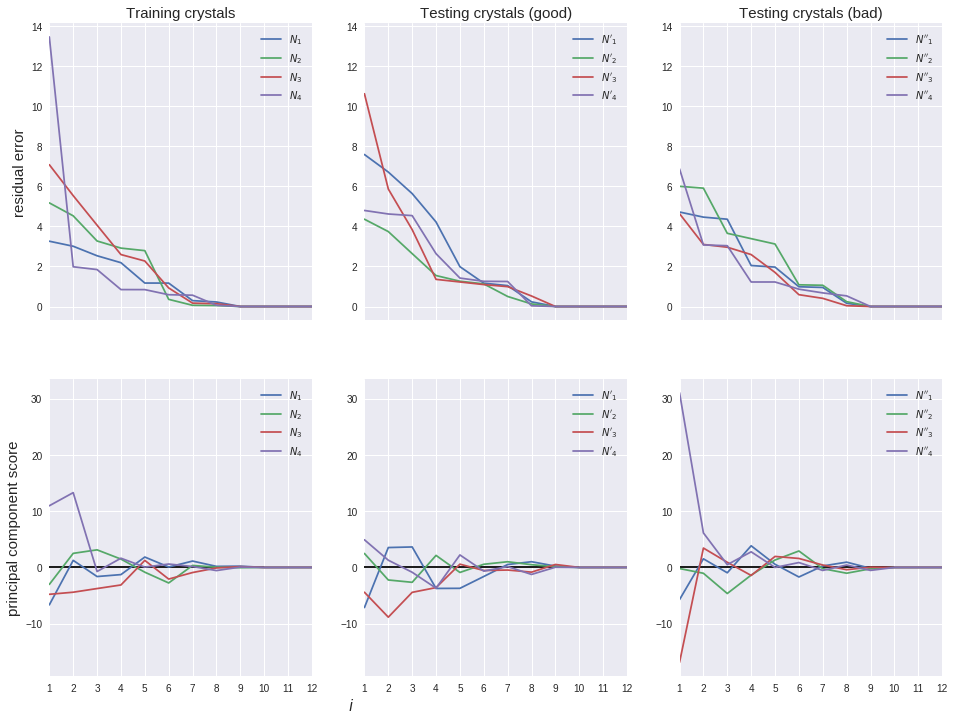

In [15]:
plot_n = 4

r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)

fig, [[ax1, ax4], [ax9, ax10]] = plt.subplots(2,2, figsize=(16,6))
plt.suptitle(r"Singular values and top 3 singular vectors", fontsize=20)

fig, [[ax2, ax3, ax7], [ax5, ax6, ax8]] = plt.subplots(2,3, figsize=(16,12), sharex=True)

ax1.plot(range(1, len(s)+1), s)
ax1.hlines(0, 1, 10)
ax1.set_ylabel(r'$\sigma_i$', fontsize=15)

for n in range(plot_n):
    err = [np.linalg.norm(A[n,:m].dot(V[:, :m].T) - D[n]) for m in range(1, len(s)+1)]
    ax2.plot(range(1, len(s)+1), err, label=r"$N_{{{}}}$".format(n+1))
    ax2.set_ylabel('residual error', fontsize=15)
ax2.legend(loc=1)

for n in range(plot_n):
    new = D_test[n,:]
    comp = np.array([new.dot(V.T[i]) for i in range(len(s))])
    err = [np.linalg.norm((comp[np.newaxis, :m] * V[:, :m]).sum(1) - new) for m in range(1, len(s)+1)]
    #err = [np.linalg.norm(comp.dot(V[:, :m]) - new) for m in range(1, len(s)+1)]
    ax3.plot(range(1, len(s)+1), err, label=r"$N'_{{{}}}$".format(n+1))
ax3.legend(loc=1)

ax4.plot(r, V[:,0])
ax4.set_ylabel(r'$V_1$')
ax9.plot(r, V[:,1])
ax9.set_ylabel(r'$V_2$')
ax10.plot(r, V[:,2])
ax10.set_ylabel(r'$V_3$')

for n in range(plot_n):
    #comp = [np.linalg.norm(A[n,:m].dot(V[:, :m].T) - D[n]) for m in range(1, len(s)+1)]
    comp = A[n]
    ax5.plot(range(1, len(s)+1), comp, label=r"$N_{{{}}}$".format(n+1))
    ax5.set_ylabel('principal component score', fontsize=15)
ax5.set_xlabel(r'$i$', fontsize=15, x=1.15)
ax5.hlines(0, 1, 10)
ax5.legend(loc=1)



for n in range(plot_n):
    new = D_test[n]
    comp = [new.dot(V.T[i]) for i in range(len(s))]
    ax6.plot(range(1, len(s)+1), comp, label = r"$N'_{{{}}}$".format(n+1))
ax6.legend(loc=1)
ax6.hlines(0, 1, 10)
ax1.xaxis.set_ticks(range(1,21))
ax2.xaxis.set_ticks(range(1,21))
ax3.xaxis.set_ticks(range(1,21))
ax5.xaxis.set_ticks(range(1,21))
ax6.xaxis.set_ticks(range(1,21))
ax6.set_xlim(1, 12)
ax6.legend(loc=1)

def set_ax_samey(ax1, ax2):
    min_1, max_1 = ax1.get_ylim()
    min_2, max_2 = ax2.get_ylim()
    ax1.set_ylim(min(min_1, min_2), max(max_1, max_2))
    ax2.set_ylim(min(min_1, min_2), max(max_1, max_2))
set_ax_samey(ax5, ax6)
set_ax_samey(ax2, ax3)

for n in range(plot_n):
    new = D_test2[n,:]
    comp = np.array([new.dot(V.T[i]) for i in range(len(s))])
    err = [np.linalg.norm((comp[np.newaxis, :m] * V[:, :m]).sum(1) - new) for m in range(1, len(s)+1)]
    #err = [np.linalg.norm(comp.dot(V[:, :m]) - new) for m in range(1, len(s)+1)]
    ax7.plot(range(1, len(s)+1), err, label=r"$N''_{{{}}}$".format(n+1))
ax7.legend(loc=1)

for n in range(plot_n):
    new = D_test2[n]
    comp = [new.dot(V.T[i]) for i in range(len(s))]
    ax8.plot(range(1, len(s)+1), comp, label = r"$N''_{{{}}}$".format(n+1))
ax8.legend(loc=1)
ax8.hlines(0, 1, 10)
ax8.set_xlim(1, 12)
ax8.legend(loc=1)

def set_ax_samey(*axs):
    mins = []
    maxs = []
    for ax in axs:
        min_i, max_i = ax.get_ylim()
        mins.append(min_i)
        maxs.append(max_i)
    for ax in axs:
        ax.set_ylim(min(mins), max(maxs))
set_ax_samey(ax5, ax6, ax8)
set_ax_samey(ax2, ax3, ax7)


ax2.set_title('Training crystals', fontsize=15)
ax3.set_title('Testing crystals (good)', fontsize=15)
ax7.set_title('Testing crystals (bad)', fontsize=15)

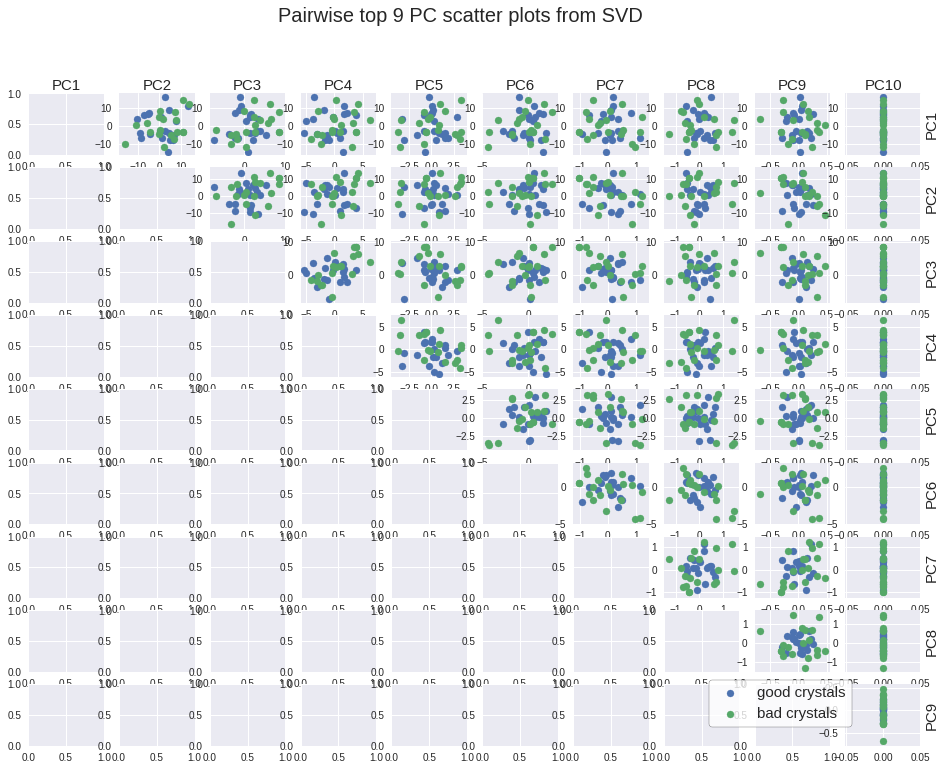

In [149]:
N_crystals = 20

N1_good = get_dN(N_crystals, log01)
N1_bad = get_dN(1000 + N_crystals, log01, 1001)

# directly computed from SVD
U, s, Vt = np.linalg.svd(N1_good)
V = Vt.T
S = np.diag(s)

PC_good = U.dot(S)
PC_bad = N1_bad.dot(V)

N_pc = 10

fig, axarr = plt.subplots(N_pc - 1, N_pc, figsize=(16,12))

for row in range(N_pc):
    for col in range(row+1, N_pc):
        try:
            axarr[row, col].scatter(PC_good[:,col], PC_good[:,row], label='good crystals')
            axarr[row, col].scatter(PC_bad[:,col], PC_bad[:,row], label='bad crystals')
        except:
            pass

# axarr[row, col].set_xlabel('PC%d' % (row + 1))
# axarr[row, col].set_ylabel('PC%d' % (col + 1))
for col in range(N_pc):
    axarr[0, col].set_xlabel('PC%d' % (col + 1), fontsize=15)
    axarr[0, col].xaxis.set_label_position('top')
    
for row in range(N_pc-1):
    axarr[row, -1].set_ylabel('PC%d' % (row + 1), fontsize=15)
    axarr[row, -1].yaxis.set_label_position('right')
plt.suptitle("Pairwise top 9 PC scatter plots from SVD", fontsize=20)

legend = axarr[N_pc - 2, N_pc -1].legend(loc=(-1.8, 0.3), fontsize=15, frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

From plain PCA, it is difficult to classify good/bad crystals by simply looking at it. Some more complex model is therefore necessary.

## Attempt to classify good/bad crystals using machine learning

* **Descriptor**: list of singular vector coefficients of $\Delta N_{\rm AlAs}(r)$, calculated by SVD of top 50 crystals of the first optimization run
* **Model**: Defualt adaptive boosting decision tree (adaboos)
* **Dataset**: 1200 crystals in total, 600 good and 600 bad. 100 best and 100 worst crystals from each optimization run (6 optimization runs in total).
* **Validatoin**: 10% of the data is used as test set

In [168]:
N_crystals = 100
bad_start = 1000

logs = [log01, log02, log03, log04, log05, log06]
N_good = []
N_bad = []
for log in logs:
    # 1 - 100 crystals, sorted by bandgap
    N_good.append(get_dN(N_crystals, log))
    # 951 - 1050 crystals, sorted by bandgap
    N_bad.append(get_dN(bad_start + N_crystals, log, bad_start))
N_good = np.vstack(N_good)
N_bad = np.vstack(N_bad)
print N_good.shape, N_bad.shape

In [170]:
U, s, Vt = np.linalg.svd(N_good[:50])
V = Vt.T
S = np.diag(s)

In [187]:
PC_root = U.dot(S)[:, :10]
PC_good = N_good.dot(V)[:, :10]
PC_bad = N_bad.dot(V)[:, :10]

In [186]:
label_good = np.ones(len(PC_good))
label_bad = np.zeros(len(PC_bad))

In [212]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

X = np.vstack([PC_good, PC_bad])
y = np.hstack([label_good, label_bad])

model = AdaBoostClassifier(random_state=42)
trees = []
for min_split in [2, 5, 10, 20]:
    for depth in [None, 2, 5, 10]:
        base_model = DecisionTreeClassifier(
            min_samples_split=min_split,
            max_depth=depth,
        )
        trees.append(base_model)
parameters = {
    'n_estimators': [10, 20, 50, 100, 200],
    'base_estimator': trees
}

cv = StratifiedKFold(
    random_state=0,
    shuffle=True,
)

clf = GridSearchCV(model, parameters)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200], 'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight...t=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [215]:
clf.cv_results_['mean_test_score'].mean()

0.54891666666666672

## DISAGREE WITH SKLEARN PCA RESULTS

SVD and PCA are equivalent only when the mean of data is zero. Since it is not really reasonable to take the mean of radial distribution, my initial approach is to find SVD orthogonal basis for the radial distributions. It is therefore meamingful to check the consistancy with standard packages such as sklearn by manually centering/normalizing the data. 

However, the results are **NOT CONSISTENT**. There maybe some approximation made in sklearn package. Since I can also calculate the eigendicompoision of the covariance matrix, the consistancy check indicates that there are some problem with sklearn PCA routines (or simply I did not set it up properly).

/home/samio/local/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


(15, 5876)
(15, 15) (15, 15)


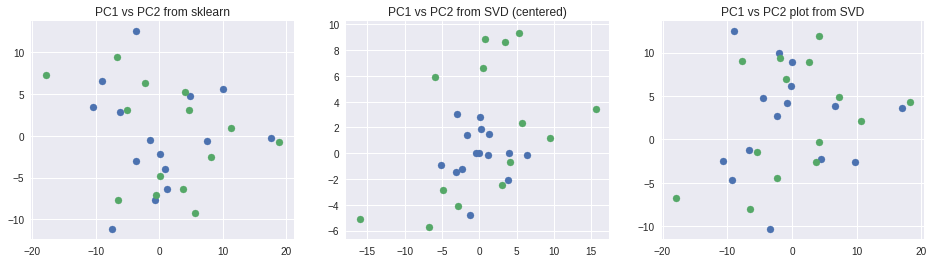

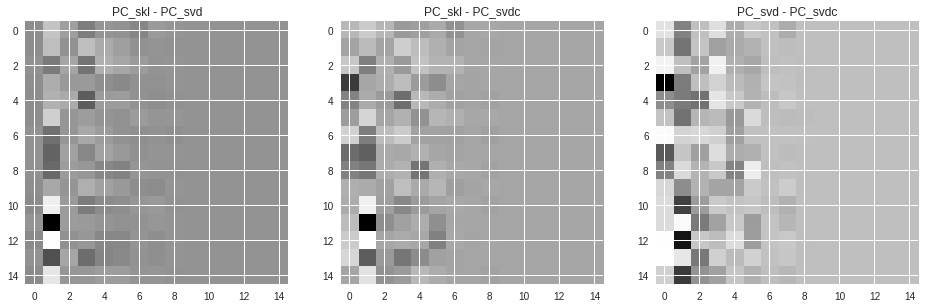

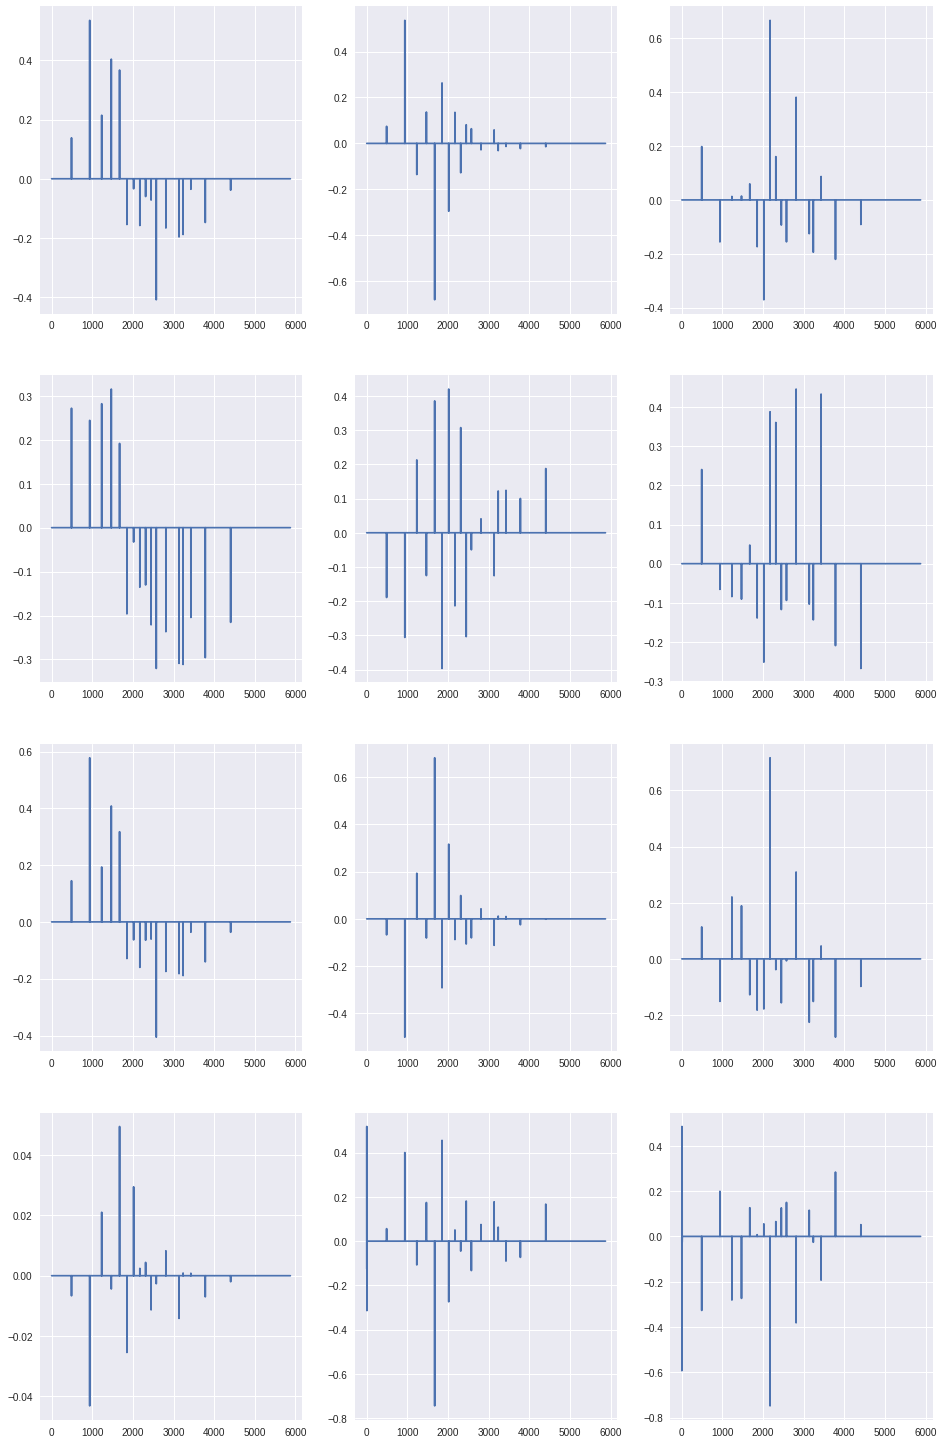

In [203]:
N_crystals = 15

N1_good = get_dN(N_crystals, log01)
N1_bad = get_dN(1000 + N_crystals, log01, 1001)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16,4))

# get SVD within sklearn PCA object
pca = PCA(n_components=N_crystals, svd_solver='full').fit(N1_good)
PC_skl = pca.transform(N1_good)
PC_skl_bad = pca.transform(N1_bad)
ax1.scatter(PC_skl[:,0], PC_skl[:,1])
ax1.scatter(PC_skl_bad[:,0], PC_skl_bad[:,1])
ax1.set_title("PC1 vs PC2 from sklearn", fontsize=12)

# directly computed from SVD on centered data
N1_good_diff = N1_good - N1_good.mean(0)[np.newaxis, :]
N1_good_diff = np.nan_to_num(N1_good_diff / N1_good_diff.std(0)[np.newaxis, :])
print N1_good_diff.shape
Uc, sc, Vct = np.linalg.svd(N1_good_diff)
Vc = Vct.T
Sc = np.diag(sc)

PC_svdc = Uc.dot(Sc)
PC_svdc_bad = N1_bad.dot(Vc)
#PC = U

ax2.scatter(PC_svdc[:, 0], PC_svdc[:, 1])
ax2.scatter(PC_svdc_bad[:, 0], PC_svdc_bad[:, 1])
ax2.set_title("PC1 vs PC2 from SVD (centered)", fontsize=12)

# directly computed from SVD
U, s, Vt = np.linalg.svd(N1_good)
V = Vt.T
S = np.diag(s)

PC_svd = U.dot(S)
PC_svd_bad = N1_bad.dot(V)
#PC = U

ax3.scatter(PC_svd[:, 0], PC_svd[:, 1])
ax3.scatter(PC_svd_bad[:, 0], PC_svd_bad[:, 1])
ax3.set_title("PC1 vs PC2 plot from SVD", fontsize=12)

print PC_skl.shape, PC_svd.shape
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16,5))
ax1.set_title("PC_skl - PC_svd")
ax1.imshow(PC_skl - PC_svd)

ax2.set_title("PC_skl - PC_svdc")
ax2.imshow(PC_skl - PC_svdc)

ax3.set_title("PC_svd - PC_svdc")
ax3.imshow(PC_svd - PC_svdc)

fig, axarr = plt.subplots(4, 3, figsize=(16,26))
for i in range(3):
    axarr[0, i].plot(pca.components_[i])
    axarr[1, i].plot(Vc[:, i])
    axarr[2, i].plot(V[:, i])
    axarr[3, i].plot(pca.components_[-i] - V[:,i])

## Eigendecomposition of covariance matrix

The result shows eigenvector of covariance matrix is almost identical with the (without centering) SVD right singular vectors

In [99]:
X = N1_good.copy()
X -= X.mean(0)
C = np.cov(X.T)
S_test, V_test = np.linalg.eig(C)

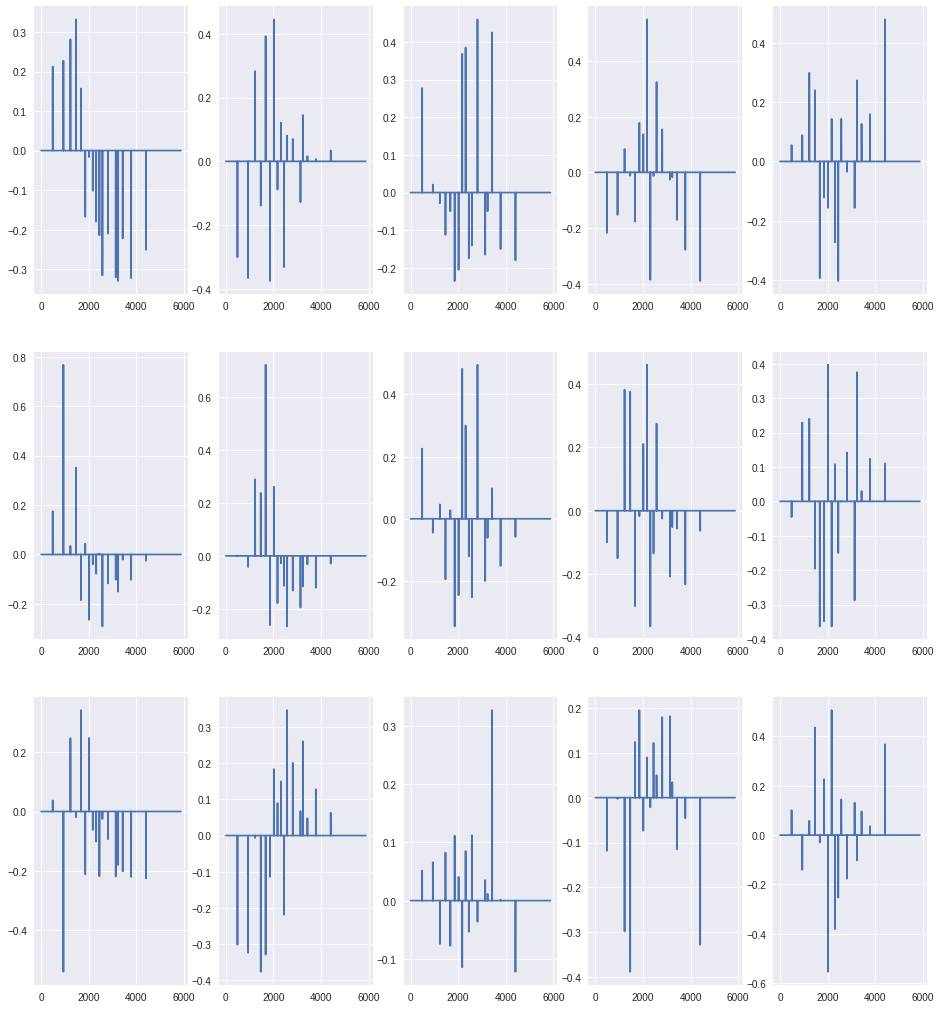

In [134]:
N_comp = 5

fig, axarr = plt.subplots(3, N_comp, figsize=(16,18))
for i in range(N_comp):
    vt = V_test[:, i].real
    vt = vt * np.sign(vt[np.argmax(abs(vt))])
    v = Vc[:, i]
    v = v * np.sign(v[np.argmax(abs(v))])
    axarr[0, i].plot(v)
    axarr[1, i].plot(vt)
    axarr[2, i].plot(v-vt)